In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import ot 
import os

path_folder='/home/baly/projects/PGW_Metric'
os.chdir(path_folder)
cwd = os.getcwd()
print(cwd)
import numba as nb
#os.chdir(parent_path)

# import our gw, (bounded) pgw, mpgw 

from lib.gromov import gromov_wasserstein,cost_matrix_d,tensor_dot_param,tensor_dot_func,gwgrad_partial1,partial_gromov_wasserstein,partial_gromov_ver1,GW_dist,MPGW_dist,PGW_dist_with_penalty

# import ugw 

from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure
from lib.unbalanced_gromov_wasserstein.unbalancedgw.batch_stable_ugw_solver import log_batch_ugw_sinkhorn


from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS


/home/baly/projects/PGW_Metric


In [2]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

In [3]:
from ot.utils import dist, UndefinedParameter, list_to_array
from ot.optim import cg, line_search_armijo, solve_1d_linesearch_quad
from ot.utils import check_random_state, unif
from ot.backend import get_backend, NumpyBackend

def gromov_barycenters(
        N, Cs, ps=None, p=None, lambdas=None, loss_fun='square_loss',
        symmetric=True, armijo=False, max_iter=1000, tol=1e-9,
        stop_criterion='barycenter', warmstartT=False, verbose=False,
        log=False, init_C=None, random_state=None, **kwargs):
    r"""
    Returns the Gromov-Wasserstein barycenters of `S` measured similarity matrices :math:`(\mathbf{C}_s)_{1 \leq s \leq S}`

    The function solves the following optimization problem with block coordinate descent:

    .. math::

        \mathbf{C}^* = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    N : int
        Size of the targeted barycenter
    Cs : list of S array-like of shape (ns, ns)
        Metric cost matrices
    ps : list of S array-like of shape (ns,), optional
        Sample weights in the `S` spaces.
        If let to its default value None, uniform distributions are taken.
    p : array-like, shape (N,), optional
        Weights in the targeted barycenter.
        If let to its default value None, uniform distribution is taken.
    lambdas : list of float, optional
        List of the `S` spaces' weights.
        If let to its default value None, uniform weights are taken.
    loss_fun : callable, optional
        tensor-matrix multiplication function based on specific loss function
    symmetric : bool, optional.
        Either structures are to be assumed symmetric or not. Default value is True.
        Else if set to True (resp. False), C1 and C2 will be assumed symmetric (resp. asymmetric).
    armijo : bool, optional
        If True the step of the line-search is found via an armijo research.
        Else closed form is used. If there are convergence issues use False.
    max_iter : int, optional
        Max number of iterations
    tol : float, optional
        Stop threshold on relative error (>0)
    stop_criterion : str, optional. Default is 'barycenter'.
        Stop criterion taking values in ['barycenter', 'loss']. If set to 'barycenter'
        uses absolute norm variations of estimated barycenters. Else if set to 'loss'
        uses the relative variations of the loss.
    warmstartT: bool, optional
        Either to perform warmstart of transport plans in the successive
        fused gromov-wasserstein transport problems.s
    verbose : bool, optional
        Print information along iterations.
    log : bool, optional
        Record log if True.
    init_C : bool | array-like, shape(N,N)
        Random initial value for the :math:`\mathbf{C}` matrix provided by user.
    random_state : int or RandomState instance, optional
        Fix the seed for reproducibility

    Returns
    -------
    C : array-like, shape (`N`, `N`)
        Similarity matrix in the barycenter space (permutated arbitrarily)
    log : dict
        Only returned when log=True. It contains the keys:

        - :math:`\mathbf{T}`: list of (`N`, `ns`) transport matrices
        - :math:`\mathbf{p}`: (`N`,) barycenter weights
        - values used in convergence evaluation.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """
    if stop_criterion not in ['barycenter', 'loss']:
        raise ValueError(f"Unknown `stop_criterion='{stop_criterion}'`. Use one of: {'barycenter', 'loss'}.")

    Cs = list_to_array(*Cs)
    arr = [*Cs]
    if ps is not None:
        arr += list_to_array(*ps)
    else:
        ps = [unif(C.shape[0], type_as=C) for C in Cs]
    if p is not None:
        arr.append(list_to_array(p))
    else:
        p = unif(N, type_as=Cs[0])

    nx = get_backend(*arr)

    S = len(Cs)
    if lambdas is None:
        lambdas = [1. / S] * S

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = dist(xalea, xalea)
        C /= C.max()
        C = nx.from_numpy(C, type_as=p)
    else:
        C = init_C

    cpt = 0
    err = 1e15  # either the error on 'barycenter' or 'loss'

    if warmstartT:
        T = [None] * S

    if stop_criterion == 'barycenter':
        inner_log = False
    else:
        inner_log = True
        curr_loss = 1e15

    if log:
        log_ = {}
        log_['err'] = []
        if stop_criterion == 'loss':
            log_['loss'] = []

    while (err > tol and cpt < max_iter):
        if stop_criterion == 'barycenter':
            Cprev = C
        else:
            prev_loss = curr_loss

        # get transport plans
        if warmstartT:
            res = [gromov_wasserstein(
                C, Cs[s], p, ps[s], loss_fun, symmetric=symmetric, armijo=armijo, G0=T[s],
                max_iter=max_iter, tol_rel=1e-5, tol_abs=0., log=inner_log, verbose=verbose, **kwargs)
                for s in range(S)]
        else:
            res = [gromov_wasserstein(
                C, Cs[s], p, ps[s], loss_fun, symmetric=symmetric, armijo=armijo, G0=None,
                max_iter=max_iter, tol_rel=1e-5, tol_abs=0., log=inner_log, verbose=verbose, **kwargs)
                for s in range(S)]

        T = res

        # update barycenters
        if loss_fun == 'square_loss':
            C = pgw_update_square_loss_nb(p, lambdas, T, Cs)        

        # update convergence criterion
        #if stop_criterion == 'barycenter':
        err = nx.norm(C - Cprev)
        if log:
            log_['err'].append(err)

        if verbose:
            if cpt % 200 == 0:
                print('{:5s}|{:12s}'.format(
                    'It.', 'Err') + '\n' + '-' * 19)
            print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        log_['T'] = T
        log_['p'] = p

        return C, log_
    else:
        return C

In [4]:
def update_square_loss(p, lambdas, T, Cs, nx=None):
    r"""
    Updates :math:`\mathbf{C}` according to the L2 Loss kernel with the `S`
    :math:`\mathbf{T}_s` couplings calculated at each iteration of the GW
    barycenter problem in :ref:`[12]`:

    .. math::

        \mathbf{C}^* = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    p : array-like, shape (N,)
        Masses in the targeted barycenter.
    lambdas : list of float
        List of the `S` spaces' weights.
    T : list of S array-like of shape (N, ns)
        The `S` :math:`\mathbf{T}_s` couplings calculated at each iteration.
    Cs : list of S array-like, shape(ns,ns)
        Metric cost matrices.
    nx : backend, optional
        If let to its default value None, a backend test will be conducted.

    Returns
    ----------
    C : array-like, shape (`nt`, `nt`)
        Updated :math:`\mathbf{C}` matrix.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """
    if nx is None:
        nx = get_backend(p, *T, *Cs)
    # Correct order mistake in Equation 14 in [12]
    tmpsum = sum([
        lambdas[s] * nx.dot(
            nx.dot(T[s], Cs[s]),
            T[s].T
        ) for s in range(len(T))
    ])
    ppt = nx.outer(p, p)

    return tmpsum / ppt


In [5]:
#@nb.njit(cache=True)
def pgw_update_square_loss(p, lambdas, T, Cs):
    r"""
    Updates :math:`\mathbf{C}` according to the L2 Loss kernel with the `S`
    :math:`\mathbf{T}_s` couplings calculated at each iteration of the GW
    barycenter problem in :ref:`[12]`:

    .. math::

        \mathbf{C}^* = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    p : array-like, shape (N,)
        Masses in the targeted barycenter.
    lambdas : list of float
        List of the `S` spaces' weights.
    T : list of S array-like of shape (N, ns)
        The `S` :math:`\mathbf{T}_s` couplings calculated at each iteration.
    Cs : list of S array-like, shape(ns,ns)
        Metric cost matrices.
    nx : backend, optional
        If let to its default value None, a backend test will be conducted.

    Returns
    ----------
    C : array-like, shape (`nt`, `nt`)
        Updated :math:`\mathbf{C}` matrix.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """

    # Correct order mistake in Equation 14 in [12]
    tmpsum = sum([
        lambdas[s] * np.dot(
            np.dot(T[s], Cs[s]),
            T[s].T
        ) for s in range(len(T))
    ])
    
    ppt =sum([
        lambdas[s] * np.outer(T[s].sum(1), T[s].sum(1))
        for s in range(len(T))
    ])
    
    return tmpsum / ppt

In [6]:
@nb.njit(cache=True)
def pgw_update_square_loss_nb(p, lambdas, T, Cs):
    r"""
    Updates :math:`\mathbf{C}` according to the L2 Loss kernel with the `S`
    :math:`\mathbf{T}_s` couplings calculated at each iteration of the GW
    barycenter problem in :ref:`[12]`:

    .. math::

        \mathbf{C}^* = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    p : array-like, shape (N,)
        Masses in the targeted barycenter.
    lambdas : list of float
        List of the `S` spaces' weights.
    T : list of S array-like of shape (N, ns)
        The `S` :math:`\mathbf{T}_s` couplings calculated at each iteration.
    Cs : list of S array-like, shape(ns,ns)
        Metric cost matrices.
    nx : backend, optional
        If let to its default value None, a backend test will be conducted.

    Returns
    ----------
    C : array-like, shape (`nt`, `nt`)
        Updated :math:`\mathbf{C}` matrix.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """

    # Correct order mistake in Equation 14 in [12]
    N,n=len(T),p.shape[0]
    tmpsum,ppt=np.zeros((n,n)),np.zeros((n,n))
    for s in range(N):
        tmpsum+=lambdas[s] * np.dot(np.dot(T[s], Cs[s]),T[s].T)
        T1=T[s].sum(1)
        ppt+=lambdas[s] * np.outer(T1, T1)    
    return tmpsum / ppt

In [7]:
def pgw_barycenters(
        N, Cs, ps=None, p=None, Lambda_list=None,lambdas=None, loss_fun='square_loss', max_iter=1000, tol=1e-9, verbose=False,
        log=False, init_C=None, random_state=None,stop_criterion='barycenter', **kwargs):
    r"""
    Returns the Gromov-Wasserstein barycenters of `S` measured similarity matrices :math:`(\mathbf{C}_s)_{1 \leq s \leq S}`

    The function solves the following optimization problem with block coordinate descent:

    .. math::

        \mathbf{C}^* = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    N : int
        Size of the targeted barycenter
    Cs : list of S array-like of shape (ns, ns)
        Metric cost matrices
    ps : list of S array-like of shape (ns,), optional
        Sample weights in the `S` spaces.
        If let to its default value None, uniform distributions are taken.
    p : array-like, shape (N,), optional
        Weights in the targeted barycenter.
        If let to its default value None, uniform distribution is taken.
    lambdas : list of float, optional
        List of the `S` spaces' weights.
        If let to its default value None, uniform weights are taken.
    loss_fun : callable, optional
        tensor-matrix multiplication function based on specific loss function
    symmetric : bool, optional.
        Either structures are to be assumed symmetric or not. Default value is True.
        Else if set to True (resp. False), C1 and C2 will be assumed symmetric (resp. asymmetric).
    armijo : bool, optional
        If True the step of the line-search is found via an armijo research.
        Else closed form is used. If there are convergence issues use False.
    max_iter : int, optional
        Max number of iterations
    tol : float, optional
        Stop threshold on relative error (>0)
    stop_criterion : str, optional. Default is 'barycenter'.
        Stop criterion taking values in ['barycenter', 'loss']. If set to 'barycenter'
        uses absolute norm variations of estimated barycenters. Else if set to 'loss'
        uses the relative variations of the loss.
    warmstartT: bool, optional
        Either to perform warmstart of transport plans in the successive
        fused gromov-wasserstein transport problems.s
    verbose : bool, optional
        Print information along iterations.
    log : bool, optional
        Record log if True.
    init_C : bool | array-like, shape(N,N)
        Random initial value for the :math:`\mathbf{C}` matrix provided by user.
    random_state : int or RandomState instance, optional
        Fix the seed for reproducibility

    Returns
    -------
    C : array-like, shape (`N`, `N`)
        Similarity matrix in the barycenter space (permutated arbitrarily)
    log : dict
        Only returned when log=True. It contains the keys:

        - :math:`\mathbf{T}`: list of (`N`, `ns`) transport matrices
        - :math:`\mathbf{p}`: (`N`,) barycenter weights
        - values used in convergence evaluation.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """
    if stop_criterion not in ['barycenter']:
        raise ValueError(f"Unknown `stop_criterion='{stop_criterion}'`. Use one of: {'barycenter', 'loss'}.")

    Cs = list_to_array(*Cs)
    arr = [*Cs]
    if ps is not None:
        arr += list_to_array(*ps)
    else:
        ps = [unif(C.shape[0], type_as=C) for C in Cs]
    if p is not None:
        arr.append(list_to_array(p))
    else:
        p = unif(N, type_as=Cs[0])

    nx = get_backend(*arr)

    S = len(Cs)
    if lambdas is None:
        lambdas = [1. / S] * S

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = cost_matrix_d(xalea,xalea)
        C /= C.max()
        C = nx.from_numpy(C, type_as=p)
    else:
        C = init_C

    cpt = 0
    err = 1e15  # either the error on 'barycenter' or 'loss'

        
    if Lambda_list is None:
        Lambda_list=np.full(S,10.0)

    if stop_criterion == 'barycenter':
        inner_log = False
    else:
        inner_log = True
        curr_loss = 1e15

    if log:
        log_ = {}
        log_['err'] = []
        if stop_criterion == 'loss':
            log_['loss'] = []

    while (err > tol and cpt < max_iter):
        if stop_criterion == 'barycenter':
            Cprev=C.copy()
        
                              

        # get transport plans
        res = [partial_gromov_ver1(
                C, Cs[s], p, ps[s], Lambda_list[s], G0=None,
                numItermax_gw=max_iter, tol=1e-5, log=inner_log, verbose=verbose, **kwargs)
                for s in range(S)]
       
        T = res
        # else:
        #     T = [output[0] for output in res]
        #     curr_loss = np.sum([output[1]['gw_dist'] for output in res])

        # update barycenters
        if loss_fun == 'square_loss':
            C = pgw_update_square_loss_nb(p, lambdas, T, Cs)

        # elif loss_fun == 'kl_loss':
        #     C = update_kl_loss(p, lambdas, T, Cs, nx)
        
        if stop_criterion == 'barycenter':
            err = nx.norm(C - Cprev)
        if log:
            log_['err'].append(err)


        if verbose:
            if cpt % 200 == 0:
                print('{:5s}|{:12s}'.format(
                    'It.', 'Err') + '\n' + '-' * 19)
            print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        log_['T'] = T
        log_['p'] = p

        return C, log_
    else:
        return C

In [18]:
def mpgw_barycenters(
        N, Cs, ps=None, p=None, lambdas=None,mass_list=None, loss_fun='square_loss', max_iter=1000, tol=1e-9, verbose=False,
        log=False, init_C=None, stop_criterion = 'barycenter', random_state=None, **kwargs):
    r"""
    Returns the Gromov-Wasserstein barycenters of `S` measured similarity matrices :math:`(\mathbf{C}_s)_{1 \leq s \leq S}`

    The function solves the following optimization problem with block coordinate descent:

    .. math::

        \mathbf{C}^* = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    N : int
        Size of the targeted barycenter
    Cs : list of S array-like of shape (ns, ns)
        Metric cost matrices
    ps : list of S array-like of shape (ns,), optional
        Sample weights in the `S` spaces.
        If let to its default value None, uniform distributions are taken.
    p : array-like, shape (N,), optional
        Weights in the targeted barycenter.
        If let to its default value None, uniform distribution is taken.
    lambdas : list of float, optional
        List of the `S` spaces' weights.
        If let to its default value None, uniform weights are taken.
    loss_fun : callable, optional
        tensor-matrix multiplication function based on specific loss function
    symmetric : bool, optional.
        Either structures are to be assumed symmetric or not. Default value is True.
        Else if set to True (resp. False), C1 and C2 will be assumed symmetric (resp. asymmetric).
    armijo : bool, optional
        If True the step of the line-search is found via an armijo research.
        Else closed form is used. If there are convergence issues use False.
    max_iter : int, optional
        Max number of iterations
    tol : float, optional
        Stop threshold on relative error (>0)
    stop_criterion : str, optional. Default is 'barycenter'.
        Stop criterion taking values in ['barycenter', 'loss']. If set to 'barycenter'
        uses absolute norm variations of estimated barycenters. Else if set to 'loss'
        uses the relative variations of the loss.
    warmstartT: bool, optional
        Either to perform warmstart of transport plans in the successive
        fused gromov-wasserstein transport problems.s
    verbose : bool, optional
        Print information along iterations.
    log : bool, optional
        Record log if True.
    init_C : bool | array-like, shape(N,N)
        Random initial value for the :math:`\mathbf{C}` matrix provided by user.
    random_state : int or RandomState instance, optional
        Fix the seed for reproducibility

    Returns
    -------
    C : array-like, shape (`N`, `N`)
        Similarity matrix in the barycenter space (permutated arbitrarily)
    log : dict
        Only returned when log=True. It contains the keys:

        - :math:`\mathbf{T}`: list of (`N`, `ns`) transport matrices
        - :math:`\mathbf{p}`: (`N`,) barycenter weights
        - values used in convergence evaluation.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """
    if stop_criterion not in ['barycenter']:
        raise ValueError(f"Unknown `stop_criterion='{stop_criterion}'`. Use one of: {'barycenter'}.")

    Cs = list_to_array(*Cs)
    arr = [*Cs]
    if ps is not None:
        arr += list_to_array(*ps)
    else:
        ps = [unif(C.shape[0], type_as=C) for C in Cs]
    if p is not None:
        arr.append(list_to_array(p))
    else:
        p = unif(N, type_as=Cs[0])

    nx = get_backend(*arr)

    S = len(Cs)
    if lambdas is None:
        lambdas = [1. / S] * S

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = cost_matrix_d(xalea,xalea)
        C /= C.max()
        C = nx.from_numpy(C, type_as=p)
    else:
        C = init_C

    cpt = 0
    err = 1e15  # either the error on 'barycenter' or 'loss'

    # if warmstartT:
    #     T = [None] * S
        
    if mass_list is None:
        mass_list=np.zeros(K)
        for id_K in range(K):
            mass_list=np.min(p.sum(),ps[id_K].sum())
            

    if stop_criterion == 'barycenter':
        inner_log = False
    else:
        inner_log = True
        curr_loss = 1e15

    if log:
        log_ = {}
        log_['err'] = []
        if stop_criterion == 'loss':
            log_['loss'] = []

    while (err > tol and cpt < max_iter):
        #print('cpt is',cpt)
        Cprev=C.copy()
        # get transport plans
        res = [partial_gromov_wasserstein(
                C, Cs[s], p, ps[s], mass_list[s], G0=None,
                numItermax_gw=max_iter, tol=1e-5, log=inner_log, verbose=verbose, **kwargs)
                for s in range(S)]
        
       
        T = res
        # else:
        #     T = [output[0] for output in res]
        #     curr_loss = np.sum([output[1]['gw_dist'] for output in res])

        # update barycenters
        if loss_fun == 'square_loss':
            C = pgw_update_square_loss_nb(p, lambdas, T, Cs)

        # elif loss_fun == 'kl_loss':
        #     C = update_kl_loss(p, lambdas, T, Cs, nx)
        if stop_criterion == 'barycenter':
            err = nx.norm(C - Cprev)
            if log:
                log_['err'].append(err)


        if verbose:
            if cpt % 200 == 0:
                print('{:5s}|{:12s}'.format(
                    'It.', 'Err') + '\n' + '-' * 19)
            print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        log_['T'] = T
        log_['p'] = p

        return C, log_
    else:
        return C

In [22]:
q2.sum()

1.1

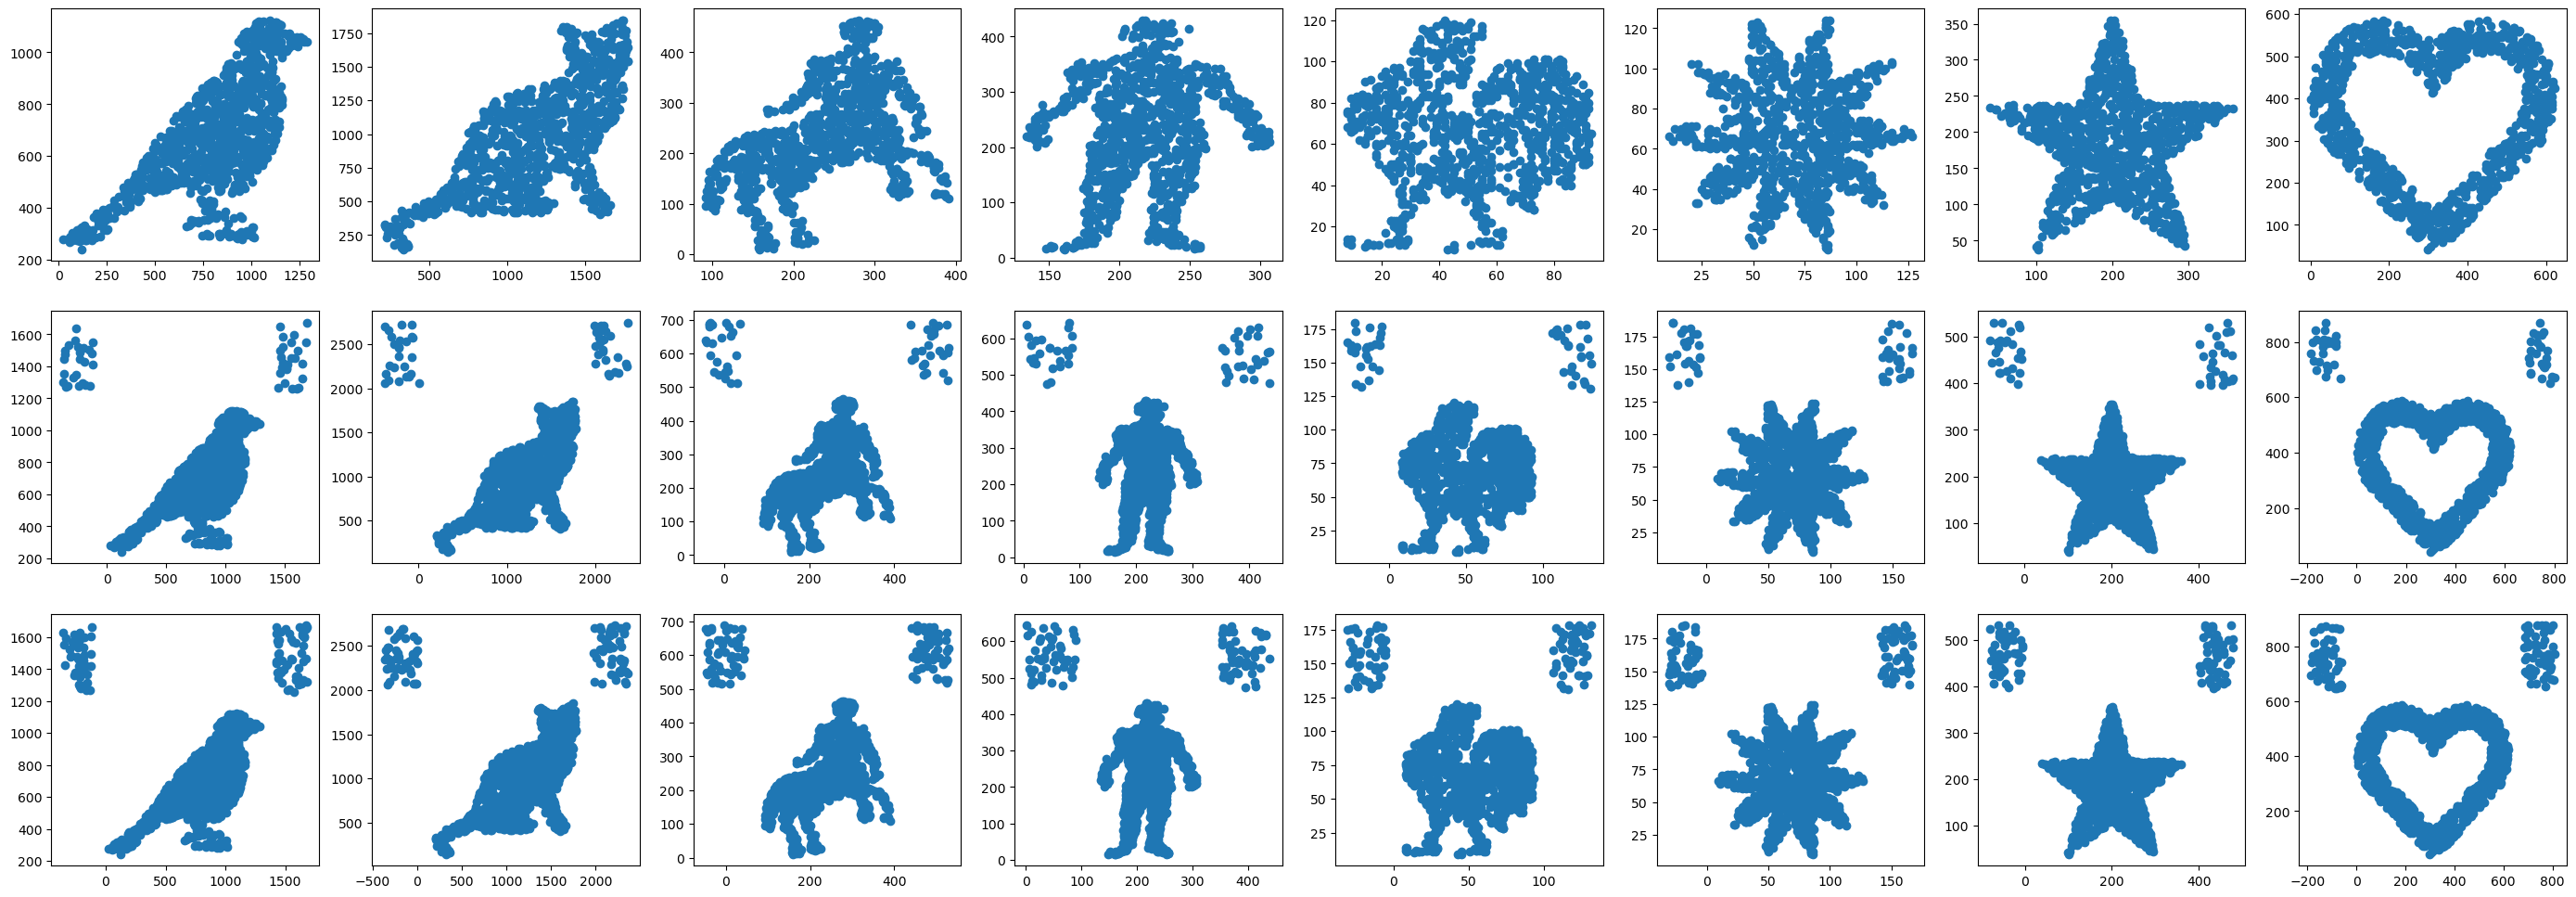

In [10]:
with open('interpolation/noise_0_point_cloud_1000.npy', 'rb') as f1:
    noise_0 = np.load(f1)
with open('interpolation/noise_p2_5_point_cloud_1000.npy', 'rb') as f2:
    noise_5 = np.load(f2)
with open('interpolation/noise_p2_10_point_cloud_1000.npy', 'rb') as f3:
    noise_10 = np.load(f3)
fig, ax = plt.subplots(3, 8, figsize=(35, 12))
for i in range(8):
    ax[0, i].scatter(noise_0[i][:,0], noise_0[i][:,1])
    ax[1, i].scatter(noise_5[i][:,0], noise_5[i][:,1])
    ax[2, i].scatter(noise_10[i][:,0], noise_10[i][:,1])
plt.show()

In [19]:
# bird to cat


T=8
t_list=np.linspace(0,1,T)
ind_task=[(0,1)]
i1,i2=ind_task[0]
N=int(noise_0[i1].shape[0]*1.0)
# GW setup in clean apply prior knowledge p, C1.max (used for visulization), C2.max (used for visulization)

X1,X2=noise_0[i1],noise_0[i2]
N1,N2=X1.shape[0],X2.shape[0]
p=np.ones(N)/N 
C1,C2=cost_matrix_d(X1,X1),cost_matrix_d(X2,X2)
C10_max,C20_max=C1.max(),C2.max()

# GW setup in noise data 
eta=10
i1,i2=ind_task[0]
X1,X2=noise_10[i1],noise_10[i2]
N1,N2=X1.shape[0],X2.shape[0]
q1,q2=np.ones(N1)/N, np.ones(N2)/N
p=np.ones(N)/N
C1,C2=cost_matrix_d(X1,X1),cost_matrix_d(X2,X2)
C1,C2=C1/C10_max,C2/C20_max 


# setup barycer problem 
Cs,qs,qs_gw=[C1,C2],[q1,q2],[q1/q1.sum(),q2/q2.sum()]
K=2
gw_list=[[] for i in range(T)]
pgw_list=[[] for i in range(T)]
Lambda_list=np.full(K,2.0)

mass_list=np.zeros(K)
mass_list[0]=min(p.sum(),q1.sum())
mass_list[1]=min(p.sum(),q2.sum())
    

# for t_id,t in enumerate(t_list):
#     print('t_id is',t_id)
#     lambdas=[t,1-t]
    
#     #normalize qs
        
#     C=ot.gromov.gromov_barycenters(
#         N=N, Cs=Cs, ps=qs_gw, p=p, lambdas=lambdas, loss_fun='square_loss',
#         symmetric=True, armijo=False, max_iter=1000, tol=1e-9)
    
#     X1t=smacof_mds(np.sqrt(C),2)
#     X1t=clf.fit_transform(X1t.copy())
#     gw_list[t_id]=(C,X1t)
    
# torch.save(gw_list,'interpolation/result/gw'+str(i1)+str(i2)+'_p2_'+str(eta)+'_'+str(N)+'.pt')





for t_id,t in enumerate(t_list):
    print('t_id is',t_id)
    lambdas=[t,1-t]
    C=mpgw_barycenters(N=N, Cs=Cs, ps=qs, p=p, mass_list=mass_list, lambdas=lambdas, loss_fun='square_loss', max_iter=1000, tol=1e-6)
    Ct_pgw_list[t_id]=C
    X1t=smacof_mds(np.sqrt(C),2)
    X1t=clf.fit_transform(X1t.copy())
    pgw_list[t_id]=(C,X1t)

torch.save(pgw_list,'interpolation/result/pgw'+str(i1)+str(i2)+'_p2_'+str(eta)+'_'+str(N)+'.pt')
# X2=clean[i2]
# ts=np.linspace(0,1,8)
# print(ts)


t_id is 0
cpt is 0
cpt is 1
cpt is 2
cpt is 3
cpt is 4
cpt is 5
cpt is 6
cpt is 7
cpt is 8
cpt is 9
cpt is 10
cpt is 11
cpt is 12
cpt is 13
cpt is 14
cpt is 15
cpt is 16
cpt is 17
cpt is 18
cpt is 19
cpt is 20
cpt is 21
cpt is 22
cpt is 23
cpt is 24
cpt is 25
cpt is 26
cpt is 27
cpt is 28
cpt is 29
cpt is 30
cpt is 31
cpt is 32
cpt is 33
cpt is 34
cpt is 35
cpt is 36
cpt is 37
cpt is 38
cpt is 39
cpt is 40
cpt is 41
cpt is 42
cpt is 43
cpt is 44
cpt is 45
cpt is 46
cpt is 47


KeyboardInterrupt: 

In [272]:

def im2mat(img):
    """Converts and image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
def smacof_mds(C, dim, max_iter=3000, eps=1e-9,seed=3):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=seed)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        n_init=1,
        normalized_stress='auto')
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        normalized_stress='auto',
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)


    return npos

from sklearn.manifold import MDS


def MDS_test(dist_mat, d,seed=0):
    mds = MDS(n_components=d, dissimilarity='precomputed',random_state=seed, normalized_stress='auto')
    lower_dimensional_points = mds.fit_transform(dist_mat)
    return lower_dimensional_points

def rotation_2d(theta=0):
    return np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]
    ])

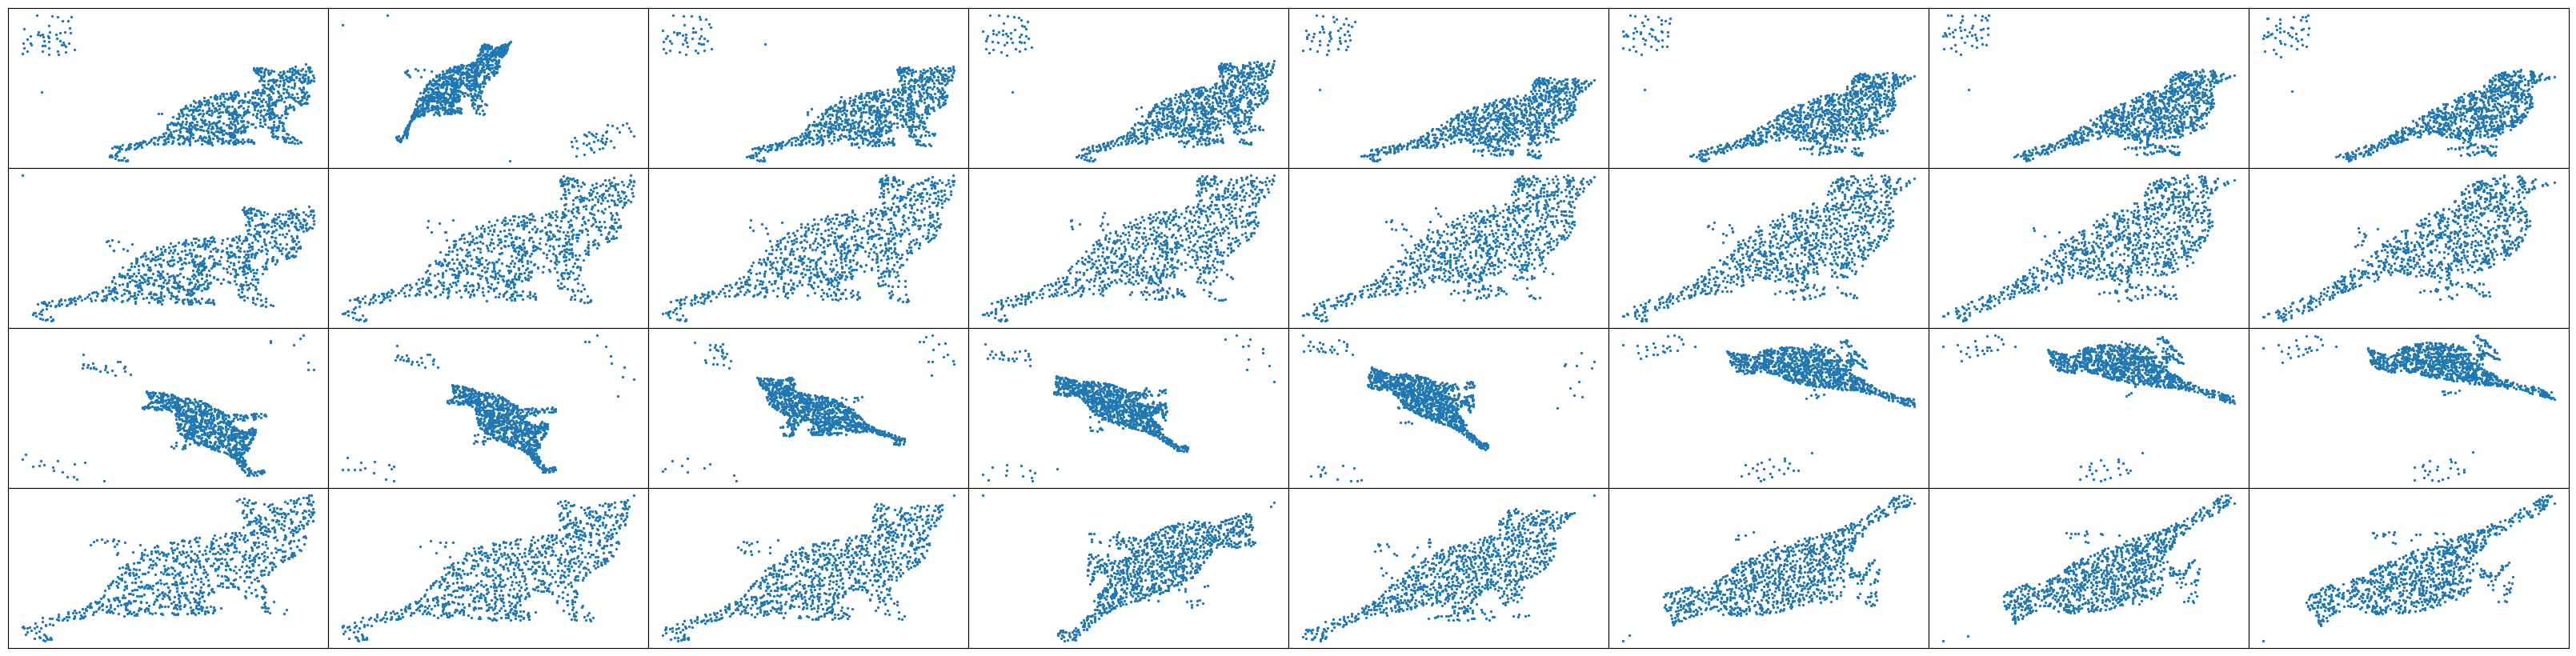

In [277]:
fig, ax = plt.subplots(4, 8, figsize=(32, 8))

# R_gw_p=np.array([-0.45*np.pi, -0.6*np.pi, 1/2*np.pi, np.pi, np.pi, np.pi, np.pi, np.pi])
# R_pgw_p=np.array([0.3*np.pi, 3/4*np.pi, 1/2*np.pi, np.pi, np.pi, np.pi, np.pi, np.pi])
flip_M=np.array([[0,1],[1,0]])

# F_gw_p_5=np.array([          0,         1,         1,     1,     1,                 1,         1,        1])
# R_gw_p_5=np.array([-0.45*np.pi, 0.3*np.pi, 1.2*np.pi, 1.4*np.pi, 1.5*np.pi, 1.5*np.pi, 1.5*np.pi, 1.5*np.pi])

# F_pgw_p_5=np.array([        1,         0,           0,          0,          0,          0,          0,       0])
# R_pgw_p_5=np.array([1.25*np.pi, 3/4*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi])

F_gw_p_5=np.array([          0,         1,         1,     1,     1,                 1,         1,        1])
R_gw_p_5=np.array([-0.45*np.pi, 0.3*np.pi, 1.2*np.pi, 1.4*np.pi, 1.5*np.pi, 1.5*np.pi, 1.5*np.pi, 1.5*np.pi])
F_pgw_p_5=np.array([        1,         0,           0,          0,          0,          0,          0,       0])
R_pgw_p_5=np.array([1.25*np.pi, 3/4*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi])

F_gw_p_10=np.array([          0,         0,         0,           0,        0,         0,         0,        0])
R_gw_p_10=np.array([-0.7*np.pi, 1.3*np.pi, 1.25*np.pi, 1.25*np.pi, 1.25*np.pi, 1.15*np.pi, 1.15*np.pi, 1.15*np.pi])
F_pgw_p_10=np.array([        0,         0,           0,          1,          0,          0,          0,       0])
R_pgw_p_10=np.array([2.73*np.pi, 3/4*np.pi, 0.75*np.pi, 1.25*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi])

eta=5
for p in [1,2]:
    if p==1:
        gw_list =torch.load('interpolation/result/gw01_p1_'+str(eta)+'_'+str(N)+'.pt')
        pgw_list=torch.load('interpolation/result/pgw01_p1_'+str(eta)+'_'+str(N)+'.pt')
        F_gw_p,R_gw_p=F_gw_p_5,R_gw_p_5
        F_pgw_p,R_pgw_p=F_pgw_p_5,R_pgw_p_5
        j1,j2=0,1
        
    if p==2:
        gw_list =torch.load('interpolation/result/gw01_p2_'+str(eta)+'_'+str(N)+'.pt')
        pgw_list=torch.load('interpolation/result/pgw01_p2_'+str(eta)+'_'+str(N)+'.pt')
        F_gw_p,R_gw_p=F_gw_p_10,R_gw_p_10
        F_pgw_p,R_pgw_p=F_pgw_p_10,R_pgw_p_10
        j1,j2=2,3

    # if eta==10:
      
    for i in range(8):        
        X1t=gw_list[i][1]
        if F_gw_p[i]:
            X1t=X1t.dot(flip_M)
        
        R=rotation_2d(R_gw_p[i])
        X1t=X1t.dot(R)

        ax[j1, i].scatter(X1t[:,0], X1t[:,1],s=2.0)
        #ax[0,i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        ax[j1,i].set_xticks([])
        ax[j1,i].set_yticks([])

        Cs_pgw=Ct_pgw_list[i]
        X1t=pgw_list[i][1]
        if F_pgw_p[i]:
            X1t=X1t.dot(flip_M)
        R=rotation_2d(R_pgw_p[i])
        X1t=X1t.dot(R)
        ax[j2, i].scatter(X1t[:,0], X1t[:,1],s=2.0)
        #ax[1,i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        ax[j2,i].set_xticks([])
        ax[j2,i].set_yticks([])
plt.tight_layout(pad=0.0)
plt.show()

In [93]:
Cs_pgw

[]

In [109]:
Lambda_list

array([2., 2.])